[目录](./table_of_contents.ipynb)

# 多元卡尔曼滤波器

过滤多个随机变量

In [27]:
%matplotlib inline

In [28]:
#format the book
import book_format
book_format.set_style()

## 概述

我们现在准备学习和实现卡尔曼滤波器的完整的多元形式。上一章我们学习了多元高斯函数如何表示多个随机变量之间的相关性，比如飞机的位置和速度。我们还了解了变量之间的相关性如何极大地改善后验。如果我们只粗略地知道位置和速度，但它们是相关的，那么我们的新估计就会非常准确。
 
我希望您通过几个示例对这些过滤器的工作方式有一个直观的认识。我要掩盖很多问题。我向你展示的一些东西只在特殊情况下有效，其他的将是“神奇的”——它将不清楚我是如何得到某个结果的。如果我从严格的，广义的方程开始，你会摸不着头脑，不知道这些术语是什么意思，也不知道如何将它们应用到你的问题中。在后面的章节中，我将提供更严格的数学基础，那时我将不得不纠正我在本章中做的近似，或者提供我在这里没有涉及的额外信息。

为了使这一切成为可能，我们将把自己限制在可以用牛顿运动方程描述的问题的一个子集内。这些滤波器称为离散连续时间运动滤波器。在**卡尔曼滤波数学**一章中，我们将发展非牛顿系统的数学。

## 牛顿运动方程

牛顿运动方程告诉我们，给定一个系统的恒定速度$v$，我们可以计算它的位置$x$在时间$t$后:

$$x = vt + x_0$$

例如，如果我们从位置13开始，速度是10m /s，我们移动了12秒，最后的位置是133 ($10\times 12 + 13$).

我们可以在这个方程中加入恒定加速度

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

假设我们匀加速运动

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

这些方程是通过对微分方程积分得到的。给定一个恒定的速度v，我们可以用这个方程计算经过时间的距离

$$x = vt + x_0$$

我们可以推导出什么

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

当你设计卡尔曼滤波器时你从一个描述系统动力学的微分方程系统开始。大多数微分方程组不容易用这种方法积分。我们从牛顿方程开始，因为我们可以积分并得到一个封闭形式的解，这使卡尔曼滤波器更容易设计。另一个好处是，牛顿方程是用来跟踪运动物体的正确方程，这是卡尔曼滤波器的主要用途之一。

## 卡尔曼滤波算法

该算法与我们在每一章中使用的贝叶斯滤波算法相同。更新步骤稍微复杂一些，但我将在我们讲到它时解释原因。

**初始化**

    1. 初始化滤波器的状态
    2. 在状态中初始化我们的信念
    
**预测**

    1. 使用过程模型来预测下一个时间步骤的状态
    2. 调整信念以解释预测中的不确定性  
**更新**

    1. 获得一个测量和相关的信念，它的准确性
    2. 计算估计状态和测量之间的残差
    3. 根据测量结果计算比例因子或者预测更准确
    4. 在预测和测量之间设置状态对比例因子
    5. 根据测量的置信度来更新状态信念  
    
作为提醒，以下是算法的图形描述:

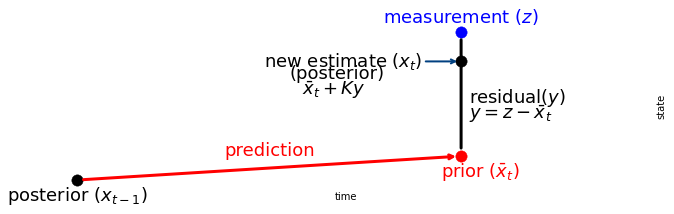

In [29]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

单变量卡尔曼滤波器用单变量高斯函数表示状态。自然，多元卡尔曼滤波器将使用多元高斯状态。我们在上一章学到多元高斯函数用一个向量表示均值，用一个矩阵表示协方差。这意味着卡尔曼滤波器需要使用线性代数来进行估计。

我不想让你们记住这些方程，但我在下面列出了单变量和多变量方程。它们非常相似。

<u>**预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

不用担心线性代数的细节，我们可以看到:

$\mathbf x,\, \mathbf P$ 是状态均值和协方差。它们对应于$x$和$\sigma^2$。


$\mathbf F$ 为状态转移函数。当乘以$\bf x$时，它计算先验。 

$\mathbf Q$ 是过程协方差。它对应于$\sigma^2_{f_x}$。

$\mathbf B$ and $\mathbf u$ 对我们来说是新的。他们让我们模拟控制系统的输入。

<u>**更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ 为测量函数。我们在这本书中还没有看到过，我稍后会解释。如果你在心里把$\mathbf H$从方程中去掉，你应该能够看到这些方程也是相似的。

$\mathbf z,\, \mathbf R$ 为测量平均值和噪声协方差。它们对应于单变量过滤器中的$z$和$\sigma_z^2$(我用$x$代替了单变量方程中的$\mu$，以使符号尽可能相似)。

$\mathbf y$和$\mathbf K$为残差和卡尔曼增益。

细节将不同于单变量过滤器，因为这些是向量和矩阵，但概念是完全相同的: 

-  使用高斯函数来表示我们对状态和误差的估计
-  用高斯函数表示测量值及其误差
-  使用高斯函数来表示过程模型
-  使用流程模型来预测下一个状态(上一个)
-  在测量和先验之间形成一个估计

作为设计师，你的工作将是设计状态$\left(\mathbf x, \mathbf P\right)$，过程$\left(\mathbf F, \mathbf Q\right)$，测量$\left(\mathbf z, \mathbf R\right)$，以及测量函数$\mathbf H$。如果系统有控制输入，比如一个机器人，你还要设计$\mathbf B$和$\mathbf u$。

我已经在FilterPy中将卡尔曼滤波器的方程编程到“预测”和“更新”函数中。您将使用:

```python
from filterpy.kalman import predict, update
```

## 追踪一只狗

让我们回到我们久经考验的真正的追踪狗的问题上来。这一次，我们将包含上一章的基本观点，并使用*隐藏变量*来改进我们的估计。我可以从数学开始，但让我们执行一个过滤器，边做边学。从表面上看，数学是不同的，可能比前几章更复杂，但思想都是一样的——我们只是乘以和添加高斯函数。

我们从为狗编写一个模拟开始。模拟将运行“计数”步骤，每一步向前移动约1米。在每个步骤中，速度将根据流程方差“ process_var ”而变化。更新位置后，我们用假定的传感器方差“z_var”计算测量值。该函数返回一个包含位置和另一个度量值的NumPy数组。

In [30]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## 预测步骤

对于预测，我们需要设计状态和协方差，过程模型和过程噪声，以及可选的控制输入。我们按顺序来。

### 设计状态变量

我们之前用高斯函数在一维中追踪了一只狗。均值$(\mu)$表示最有可能的位置，方差($\sigma^2$)表示该位置的概率分布。位置是系统的*状态*，我们称$\mu$为*状态变量*。

在这个问题中，我们将同时跟踪狗的位置和速度。这需要我们使用状态向量$\mathbf x$及其对应的协方差矩阵$\mathbf P$表示的多元高斯函数。

状态变量可以是由传感器直接测量的“观察变量”，也可以是由观察变量推导出来的“隐藏变量”。对于我们的狗跟踪问题，传感器只读取位置，因此位置被观察，速度被隐藏。我们将很快学习如何跟踪隐藏变量。

重要的是要理解跟踪位置和速度是一种带有暗示和假设的设计选择，我们还没有准备好进行探索。例如，我们还可以追踪加速度，甚至是颠动。现在，回想一下，在上一章中，我们展示了在协方差矩阵中包含速度会导致更小的位置方差。我们将在本章的后面学习卡尔曼滤波器如何计算隐藏变量的估计。

在单变量一章中，我们用标量值表示狗的位置(例如$\mu=3.27$)。在上一章中，我们学习了对多个变量使用多元高斯函数。例如，如果我们想指定一个10.0米的位置和一个4.5米/秒的速度，我们可以这样写:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

利用线性代数实现了卡尔曼滤波。我们使用$n\times 1$矩阵(称为*向量)来存储$n$状态变量。对于狗的追踪问题，我们用$x$表示位置，用$x$的一阶导数，$\dot x$表示速度。我用牛顿的点符号来表示导数;$\dot x$表示x对t的一阶导数:$\dot x = \frac{dx}{dt}$。卡尔曼滤波方程使用$\mathbf x$表示状态，因此定义$\mathbf x$为:

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$
 
我们用$\mathbf x$代替$\mu$，但请注意这是多元高斯函数的均值。
 
另一种写法是$\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$因为行向量的转置是列向量。这种符号在文本中更容易使用，因为它占用更少的垂直空间。

$\mathbf x$和位置$x$恰巧有相同的名称。如果我们在y轴上跟踪狗，我们可以写$\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$，而不是$\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$。$\mathbf x$是卡尔曼滤波文献中使用的状态变量的标准名称，我们不会改变它来给它一个更有意义的名称。这种命名的一致性允许我们与同行进行通信。
 
让我们编写代码。初始化`x`非常简单

In [31]:
x = np.array([[10.0],
              [4.5]])
x

array([[10. ],
       [ 4.5]])

 我经常在我的代码中使用转置把行矩阵变成列向量，因为我发现它更容易输入和阅读:

In [32]:
x = np.array([[10., 4.5]]).T
x

array([[10. ],
       [ 4.5]])

 然而，NumPy将1D数组识别为向量，所以我可以简化这一行，使用1D数组。

In [33]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

 所有的数组元素都有相同的类型，通常是' float '或' int '。如果列表包含所有的' int '，那么创建的数组也将具有' int '的数据类型，否则它将是' float '。我经常利用这一点，只指定一个数字为浮点数:

In [34]:
np.array([1., 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

这里有一些例子。

In [35]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.0], [4.5]])

# matrix multiply
print(np.dot(A, x))
print()

[[19.]
 [48.]]



 在Python 3.5+中，我们有矩阵乘数@，其中`np.dot(A, B) == A @ B`。这有点无用，因为它要求' A '和' B '都是数组。在本书的数学中，这些变量中的一些是标量是完全有效的，因此' @ '的效用往往会丢失。

In [36]:
# alternative matrix multiply)
print(A @ x)
print()

x = np.array([[10.0, 4.5]]).T
print(A @ x)
print()

x = np.array([10.0, 4.5])
print(A @ x)

[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]


 最后一个返回1D数组，但是我已经编写了卡尔曼过滤器类来处理这个。回想起来，这可能会导致混淆，但它确实有效。

### 设计状态协方差

状态高斯的另一半是协方差矩阵$\mathbf P$。在单变量卡尔曼滤波器中，我们指定了一个初始值$\sigma^2$，然后当测量值被添加到滤波器中时，滤波器负责更新它的值。同样的事情也发生在多维卡尔曼滤波器中。我们为$\mathbf P$指定一个初始值，过滤器在每个epoch期间更新它。
 
我们需要将方差设置为合理的值。例如，我们可以选择$ sigma_\mathtt{pos}^2=500 m^2$，如果我们对初始位置相当不确定。狗的最高速度大约是21米/秒，所以在没有任何关于速度的其他信息的情况下，我们可以设置$3\sigma_\mathtt{vel}=21$，或者$ sigma_\mathtt{vel}^2=7^2=49$。
 
在上一章中，我们说明了位置和速度是相关的。但它们对狗来说有多大的相关性呢?我不知道。我们会看到过滤器为我们计算这个，所以我将协方差初始化为零。当然，如果你知道协方差，你应该使用它们。

回想一下协方差矩阵的对角线包含每个变量的方差，而非对角线元素包含协方差。因此我们有:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

我们可以用`numpy.diag`，它根据对角线的值创建对角线矩阵。回想一下线性代数中对角线矩阵是非对角线元素为0的矩阵。

In [37]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

我可以这样写:

In [38]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

 做完了。我们已经将滤波器的状态表示为一个多元高斯函数，并在代码中实现了它。

###  设计过程模型

下一步是设计*过程模型*。它是描述系统行为的数学模型。滤波器用它来预测离散时间步长后的状态。我们用一组方程来描述系统的动力学。

在单变量一章中，我们用

$$ x = v \Delta t + x_0$$

我们的实现如下:

```python
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, 
                    pos.var + movement.var)
```
 
我们将在这一章做同样的事情，使用多元高斯函数而不是单变量高斯函数。你可以想象这样的实现:

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$
 
但是我们需要把它一般化。卡尔曼滤波方程适用于任何线性系统，而不仅仅是牛顿系统。也许你正在过滤的系统是一个化工厂的管道系统，给定管道中的流量是由不同阀门设置的线性组合决定的。

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

线性代数是表达方程组的有力方法。把这个系统

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

我们可以把它写成矩阵形式:

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$
 
如果在这个方程中执行[矩阵乘法](https://en.wikipedia.org/wiki/Matrix_multiplication#General_definition_of_the_matrix_product)，结果将是上面的两个方程。在线性代数中，我们将它写成$\mathbf{Ax}=\mathbf B$，其中

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$
 
然后我们可以使用SciPy的`linalg`包来解决$\mathbf x$:

In [39]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

我们使用过程模型来执行“创新”，因为方程告诉我们当前状态下的状态是什么。卡尔曼滤波器通过这个线性方程实现这一点，其中$\mathbf{\bar x}$是*先验*，或预测状态:

$$\mathbf{\bar x} = \mathbf{Fx}$$

我们可以明确表示为

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

 
作为卡尔曼滤波器设计者，我们的工作是指定$\mathbf F$，使$\bar{\mathbf x} = \mathbf{Fx}$执行系统的预测。为了做到这一点，每个状态函数需要一个方程。在问题$\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$中，我们需要一个方程来计算位置$x$，另一个方程来计算速度$\dot x$ 。我们已经知道位置更新的方程式:

$$\bar x = x + \dot x \Delta t$$

速度的方程是什么?对于狗的速度如何随时间变化，我们没有预测模型。在这种情况下，我们假设它保持不变 。当然，这并不完全正确，但只要速度在不发生太大变化，你就会看到过滤器表现得非常好。所以我们说

$$\bar{\dot x} = \dot x$$

这就为我们提供了系统的过程模型

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$
 
这个方程对状态中的每个变量都有一个方程，左边是孤立的。我们需要用$\bar{\mathbf x} = \mathbf{Fx}$的形式表示这组方程。重新排列条件更容易看到要做什么。

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

我们可以把它写成矩阵形式

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$
 
$\mathbf F$ 称为*状态转移函数*或*状态转移矩阵*。在后面的章节中，它将是一个真正的函数，而不是一个矩阵，所以称它为函数就更一般了。

In [40]:
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

让我们来测试这个!FilterPy有一个 `predict`方法，它通过计算$\mathbf{\bar x} = \mathbf{Fx}$来执行预测。让我们调用它，看看会发生什么。我们把位置设为10.0速度设为4.5米/秒。我们已经定义了' dt = 0.1 '，这意味着时间步长是0.1秒，所以我们期望在创新后的新位置是10.45米。速度应该不变。

In [41]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


 这工作。如果我们在一行中多次调用`predict()`，每次都会更新该值。

In [42]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


`predict()`计算创新的平均值和协方差。这是$\mathbf{\bar P}$ 经过五次预测后的值，我们在卡尔曼滤波方程中表示$\mathbf{\bar P}$。

In [43]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


检查对角线，我们发现位置方差变大了。我们在没有测量的情况下执行了五个预测步骤，我们的不确定性增加了。非对角元素变得非零-卡尔曼滤波器检测到位置和速度之间的相关性!速度的方差没有改变。
 
这是预测前后的协方差。初始值用红色实线表示，先验(预测)用黑色虚线表示。我改变了协方差和时间步长来更好地说明变化。

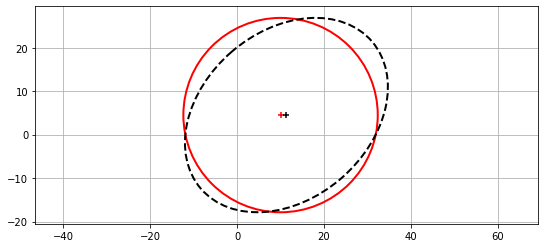

In [44]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

你可以看到，由于位置改变，椭圆的中心移动了少量(从10到11.35)。椭圆也拉长了，显示了位置和速度之间的关系。过滤器如何为$\mathbf{\bar P}$计算新值，它基于什么?注意，我每次都将过程噪声' Q '设置为零，所以这不是由于我添加了噪声。现在讨论这个还为时过早，但请记住，到目前为止，在每个过滤器中，预测步骤都会导致信息的丢失。这里也是如此。一旦我们讨论了更多的问题，我会告诉你细节。

### 设计过程噪声
 
快速回顾*过程噪声*。一辆开着定速器的汽车在路上行驶;它应该以恒定的速度运动。我们用$\bar x_k=\dot x_k\Delta t + x_{k-1}$建模。然而，它受到一些未知因素的影响。巡航控制系统不能完全保持恒定的速度。风、山坡和坑洼都会影响汽车。乘客摇下车窗，改变汽车的拖拽轮廓。

我们可以用微分方程来模拟这个系统

$$\dot{\mathbf x} = f(\mathbf x) + w$$
 
其中$f(\mathbf x)$建模状态转移，$w$是*白过程噪声*。
 
在**卡尔曼滤波器数学**一章中，我们将学习如何从一组微分方程到卡尔曼滤波器矩阵。在这一章中，我们利用了牛顿已经为我们推导出运动方程的事实。现在你只需要知道，我们通过向协方差$\mathbf P$中添加一个过程噪声协方差矩阵$\mathbf Q$来考虑系统中的噪声。我们不向$\mathbf x$添加任何东西，因为噪声是*white*——这意味着噪声的均值将为0。如果均值为0，则$\mathbf x$将不变。
 
单变量卡尔曼滤波器使用“方差=方差+ process_noise”来计算预测步骤方差的方差。多元卡尔曼滤波器做同样的事情，本质上是' P = P + Q '。我说"本质上"是因为在协方差方程中还有其他与噪声无关的术语我们稍后会看到。
 
推导过程噪声矩阵是相当困难的，我们将把它推迟到卡尔曼数学那一章。现在知道$\mathbf Q$等于白噪声$w$的期望值，计算为$\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$。在这一章中，我们将重点建立一个直观的理解如何修改这个矩阵改变过滤器的行为。

FilterPy为本章的运动学问题提供了计算$\mathbf Q$的函数。`Q_discrete_white_noise`有3个参数。`dim`表示矩阵的维数，`dt`表示时间步长，单位是秒，`var`表示噪声的方差。简单地说，在我们稍后讨论的假设下，它将给定时间段内的噪声离散化。这段代码计算$\mathbf Q$的白噪声的方差为2.35，时间步长为1秒:

In [45]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.588 1.175]
 [1.175 2.35 ]]


### 控制功能设计

卡尔曼滤波器不只是过滤数据，它允许我们整合机器人和飞机等系统的控制输入。假设我们在控制一个机器人。在每个时间步骤中，我们将根据机器人当前的位置与期望的位置向机器人发送转向和速度信号。卡尔曼滤波方程将这些知识整合到滤波方程中，根据当前速度和驱动电机的控制输入创建一个预测位置。记住，我们“从不”丢弃信息。

对于一个线性系统，控制输入的影响可以描述为一组线性方程，我们可以用线性代数表示为

$$\Delta\mathbf x = \mathbf{Bu}$$
 
这里$\mathbf u$是*控制输入*，而$\mathbf B$是*控制输入模型或*控制函数。例如，$\mathbf u$可能是一个控制车轮电机转速的电压，乘以$\mathbf B$就会得到$\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$。换句话说，它必须计算由于控制输入而改变了多少$\mathbf x$。
 
因此先验均值的完整卡尔曼滤波方程为

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$
 
这是当你调用`KalmanFilter.predict()`时计算的方程。
 
你的狗可能被训练对声音指令作出反应。所有可用的证据表明，我的狗没有任何控制输入，所以我设置$\mathbf B$为零。在Python中我们写:

In [46]:
B = 0.  # my dog doesn't listen to me!
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [12.7  4.5]
P = [[680.587 301.175]
 [301.175 502.35 ]]


将$\mathbf B$和$\mathbf u$设置为0是没有必要的，因为`predict`使用0作为它们的默认值:

In [47]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]

array([ True,  True])

In [48]:
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1]

array([[ True,  True],
       [ True,  True]])


#### 预测:总结

作为设计师，你的工作是指定矩阵

* $\mathbf x$, $\mathbf P$: 状态和协方差
* $\mathbf F$,  $\mathbf Q$: 过程模型和噪声协方差
* $\mathbf{B,u}$: 可选的，控制输入和功能

## 更新操作
 
现在我们可以实现过滤器的更新步骤。你只需要再提供两个矩阵，它们很容易理解。

### 设计测量功能
 
卡尔曼滤波器在我们称为“测量空间”的地方计算更新步骤。在单变量一章中，我们基本上忽略了这个问题，因为它增加了复杂性。我们用一个传感器来记录狗的位置。计算*残差*很容易-从测量中减去滤波器的预测位置:

$$ \mathtt{residual} = \mathtt{measured\, \, position} - \mathtt{predicted\, \, position}$$

我们需要计算残差，因为我们通过卡尔曼增益缩放它来得到新的估计。
 
如果我们试图用一个与温度读数相对应的输出电压的温度计来跟踪温度，会发生什么呢?残差计算公式没有意义;你不能用电压减去温度。

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$

我们需要把温度转换成电压，这样我们就可以做减法了。对于温度计，我们可以这样写:
 
```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```
卡尔曼滤波器通过让您提供一个将状态转换为测量值的“测量函数”来概括这个问题。

为什么我们要在测量空间工作?为什么不在状态空间中工作，把电压转换成温度，让剩余的是一个温差?
 
我们不能这样做，因为大多数测量都不是*可逆的*。跟踪问题的状态包含隐藏变量$\dot x$。没有办法把位置的测量转换成包含速度的状态。另一方面，将包含位置和速度的状态转换为只包含位置的等效“测量值”是很简单的。我们必须在测量空间中工作，使残差的计算成为可能。
 
度量值$\mathbf z$和状态$\mathbf x$都是向量，因此我们需要使用一个矩阵来执行转换。执行此步骤的卡尔曼滤波方程为:

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$
 
其中$\mathbf y$为残差，$\mathbf{\bar x}$为先验，$\mathbf z$为测量，$\mathbf H$为测量函数。所以我们取先验，将它与$\mathbf H$相乘，转化为一个测量值，然后从测量值中减去它。这给了我们在测量空间中预测和测量之间的区别!
<img src="./figs/residual_chart_with_h.png">

我们需要设计$\mathbf H$，使$\mathbf{H\bar x}$产生一个测量值。对于这个问题，我们有一个测量位置的传感器，所以$\mathbf z$将是一个变量向量:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

剩余方程是这样的

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$
 
当$\mathbf H$ 为1x1时，$\mathbf H$必须是1x2矩阵。回想一下，矩阵$m\times n$乘以$n\times p$得到一个$m\times p$矩阵。
 
我们想要用位置$x$乘以1来得到位置的相应测量值。我们不需要使用速度来找到相应的测量值，所以我们用$\dot x$乘以0。

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

对于我们设置的卡尔曼滤波器

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [49]:
H = np.array([[1., 0.]])

我们设计了大部分的卡尔曼滤波器。剩下的就是对传感器中的噪声进行建模。

####  设计测量

测量是用$\mathbf z$(测量平均值)和$\mathbf R$(测量协方差)来实现的。

$\mathbf z$很简单。它以矢量的形式包含测量值。我们只有一个度量，所以我们有:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

如果我们有两个传感器或测量，我们会有:

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$

测量噪声矩阵将传感器中的噪声建模为协方差矩阵。在实践中，这可能很困难。一个复杂的系统可能有许多传感器，它们之间的相关性可能不清楚，而且它们的噪声通常不是纯高斯噪声。例如，如果温度高，传感器可能会偏向高读数，因此噪声不是均匀分布在平均值的两边。我们以后会学会处理这些问题。

卡尔曼滤波方程使用协方差矩阵$\mathbf R$来表示测量噪声。矩阵的维数为$m{\times}m$，其中$m$是传感器的数目。它是一个协方差矩阵来说明传感器之间的相关性。我们只有一个传感器，所以R是:

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$
 
如果$\sigma^2_z$是5米的平方，那么$R = \begin{bmatrix}5\end{bmatrix}$。
 
如果我们有两个位置传感器，第一个的方差是5 m$^2$，第二个的方差是 3 m$^2$，我们会写

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$
 
我们把方差放在对角线上，因为这是一个协方差矩阵，方差在对角线上，协方差，如果有的话，在非对角线元素上。这里我们假设两个传感器之间的噪声没有相关性，所以协方差为0。

对于我们的问题，我们只有一个传感器，所以我们可以实现为

In [50]:
R = np.array([[5.]])

我们通过调用`update`来执行更新。

In [51]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.085 -0.64 ]


跟踪所有这些变量很麻烦，所以FilterPy也用类`KalmanFilter`实现了过滤器。我将在本书的其余部分使用这个类，但我想让您看看这些函数的过程形式，因为我知道有些人不喜欢面向对象编程。

## 实现卡尔曼滤波

我已经给了您过滤器的所有代码，但是现在让我们把它收集到一个地方。首先，我们构造一个`KalmanFilter`对象。我们必须用 `dim_x`参数指定状态中变量的数量，用`dim_z`参数指定测量值的数量。我们有两个状态的随机变量和一个测量值，所以我们写:

```python
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
```
这将为所有卡尔曼滤波矩阵创建一个具有默认值的对象:

In [52]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)
# etc...

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


现在我们用对问题有效的值初始化过滤器的矩阵和向量。我把它放到一个函数中，让你可以为`R`, `P`， `Q`指定不同的初始值，并把它放到一个辅助函数中。我们将创建和运行许多这些过滤器，这为我们节省了很多麻烦。

In [53]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

`KalmanFilter`初始化`R`, `P`和`Q`到单位矩阵，因此`kf.P *= P`是快速将所有对角元素赋给相同标量值的一种方法。现在我们创建过滤器:

In [54]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

您可以通过在命令行上输入变量来检查过滤器的所有属性的当前值。

In [55]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[0.    0.   ]
     [0.    0.001]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x000001DEF4B65280>

剩下的就是编写运行卡尔曼滤波器的代码。

In [56]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

这是过滤器的完整代码，其中大部分是样板。在本章中，我已经使它足够灵活，可以支持多种用途，所以它有点冗长。让我们一行一行地算一遍。 
 
第一行检查您是否在`data`中提供了测量数据。如果没有，则使用我们前面编写的`compute_dog_data`函数创建数据。

接下来的几行将使用我们的助手函数创建一个卡尔曼滤波器。

```python
# create the Kalman filter
 kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
```
我们所需要做的就是更新和预测每个测量的卡尔曼滤波器的步骤。为此，`KalmanFilter`类提供了`update()`和`predict()`两个方法。`update()`执行卡尔曼滤波器的测量更新步骤，因此它需要一个包含传感器测量的变量。

没有存储结果的工作，循环读到:

```python
    for z in zs:
        kf.predict()
        kf.update(z)
```
每次调用`predict`和`update`都会修改状态变量`x` 和`P`。因此，在调用`predict`之后，用`kf.x`包含先验。在调用更新之后， `kf.x`包含尾部。`data`包含狗的实际位置和测量值，所以我们使用`[:, 1]`来获取测量值数组。
 
没有比这更简单的了。当我们处理更复杂的问题时，这段代码在很大程度上保持不变;所有的工作都是建立`KalmanFilter` 矩阵;执行过滤器很简单。

其余代码可选地绘制结果，然后返回保存的状态和协方差。
 
让我们运行它。我们有50个测量值，噪声方差为10，过程方差为0.01。

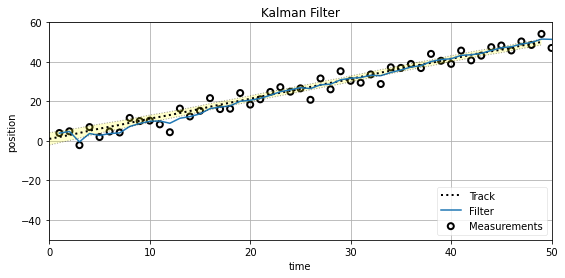

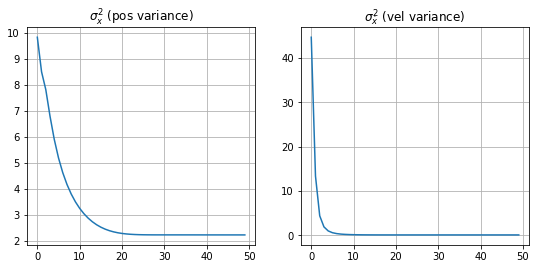

In [57]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

还有很多要学习，但我们已经实现了一个卡尔曼滤波器使用相同的理论和方程，由Rudolf Kalman发表!与此非常类似的代码在GPS、客机、机器人等内部运行。
 
第一个图根据测量值和我们的狗(标记为*Track*)的实际位置绘制出卡尔曼滤波器的输出。在初始沉降阶段之后，过滤器应该非常密切地跟踪狗的位置。黑色虚线之间的黄色阴影部分表示过滤器方差的一个标准差，我将在下一段中解释。
 
接下来的两个图显示了$x$和$\dot x$的方差。我已经绘制了$\mathbf P$的对角线随时间的变化。回想一下协方差矩阵的对角线包含了每个状态变量的方差。$\mathbf P[0,0]$是$x$的方差，$\mathbf P[1,1]$是$\dot x$的方差。可以看到，我们很快收敛到两种情况下的小方差。
 
协方差矩阵$\mathbf P$告诉我们*理论上*过滤器的性能*假设*我们所说的一切都是真的。回想一下，标准差是方差的平方根，大约68%的高斯分布发生在一个标准差内。如果至少68%的滤波器输出在一个标准偏差内，则滤波器可能表现良好。在上面的图表中，我用两条虚线之间的黄色阴影区域显示了一个标准差。在我看来，也许滤镜稍微超出了这个范围，所以过滤器可能需要一些调整。
 
在单变量一章中，我们用比上面代码简单得多的代码过滤了非常有噪声的信号。然而，请注意，我们现在正在处理一个非常简单的例子——一个物体在一维空间和一个传感器中移动。这就是我们用上一章的代码所能计算的极限。相反，我们可以用这段代码实现非常复杂的多维过滤器，只需要改变对过滤器变量的赋值即可。也许我们想要追踪金融模型中的100个维度。或者我们有一架装有GPS, INS, TACAN，雷达高度计，气压高度计和空速指示器的飞机，我们想把所有这些传感器集成到一个模型中来预测3D空间中的位置，速度和加速度。我们可以使用本章中的代码来实现这一点。
 
我想让你对高斯函数随时间的变化有一个更好的感觉，所以这里有一个3D图显示高斯函数每7个epoch(时间步长)。每七分之一就能把它们分开，让它们单独看到。第一个高斯分布在$t=0$的左边。

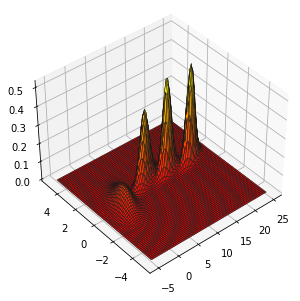

In [58]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

## 保护类

在`run()`方法中，我编写了样板代码来保存过滤器的结果
```python
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
```
有一个简单的方法可以避免这种情况。`filtery.common`提供了`Saver`类，它将在每次调用`Saver.save()`时保存卡尔曼过滤器类中的所有属性。让我们看看它是怎么运作的，然后我们会进一步讨论它。

In [59]:
from filterpy.common import Saver
kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()  # save the current state

`Saver`对象现在包含了KalmanFilter对象的所有属性列表。`kf.x`是滤波器的当前状态估计。因此`s.x`包含循环中计算的保存状态估计:

In [61]:
s.x

[array([0.531, 0.304]),
 array([1.555, 0.763]),
 array([2.784, 1.036]),
 array([3.944, 1.105]),
 array([5.015, 1.086])]

 你可以看到所有可用的属性与`keys`属性:

In [62]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

有许多属性我们还没有讨论，但许多应该是熟悉的。
 
此时，您可以编写代码来绘制这些变量中的任何一个。然而，使用`np.array`通常更有用 ，而不是列表。调用`Saver.to_array()` 将把列表转换为`np.array`。有一个警告:如果在运行过程中任何属性的形状发生了变化，`to_array`'将引发一个异常，因为`np.array`要求所有元素的类型和大小相同。
 
如果你再看一遍这些键，你会发现“z”是选项之一。这是承诺;显然，z是为我们保留的。我们把它和估计值作对比。

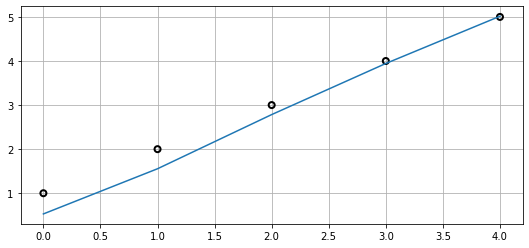

In [63]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z);
plt.plot(s.x[:, 0]);

虽然我已经用`KalmanFilter`类演示了这一点，但它将与`FilterPy`实现的所有过滤器类一起工作。它可能也适用于您编写的任何类，因为它检查对象以检索属性名。我们将在整本书中使用这个类，以保持代码的可读性和简短性。使用`Saver`会降低你的代码速度，因为很多事情都是在幕后发生的，但对于学习和探索来说，便利是无可替代的。

## 卡尔曼滤波方程
 
现在我们准备学习 `predict()`和`update()`如何执行它们的计算。

关于符号。我是一名程序员，我习惯于编写能读懂的代码

```python
x = x + 1
``` 
 
这不是一个等式，因为两边不相等，而是一个*赋值*。如果我们想用数学符号来表示

$$x_k = x_{k-1} + 1$$
 
卡尔曼滤波方程充斥着下标和上标，以保持方程在数学上的一致性。我发现这让他们很难读懂。在书中的大部分内容中，我都选择了免订阅的作业。作为一名程序员，你应该理解，我向你展示的任务，实现了一个算法，是要执行一步一步。有了具体的例子后，我会详细说明。

### 预测方程
 
卡尔曼滤波器使用这些方程来计算“先验”-预测系统的下一个状态。他们计算系统的先验均值($\bar{\mathbf x}$)和协方差($\bar{\mathbf P}$)。

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

$\underline{\textbf{Mean}}$

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

提醒一下，线性方程$\mathbf{Ax} = \mathbf b$表示一个方程组，其中$\mathbf A$包含方程组的系数，$\mathbf x$ 是变量的向量。执行$\mathbf{Ax}$的乘法运算，将计算出由$\mathbf b$表示的这组方程的右边值。
 
如果$\mathbf F$包含给定时间步长的状态转换，则乘积$\mathbf{Fx}$计算转换后的状态。简单!同样，$\mathbf B$是控制函数，$\mathbf u$是控制输入，所以$\mathbf{Bu}$计算转换后控件对状态的贡献。因此，前面的$\mathbf{\bar x}$被计算为$\mathbf{Fx}$ 和$\mathbf{Bu}$的和。

等价的单变量方程为

$$\bar\mu = \mu + \mu_{move}$$
 
如果你执行矩阵乘法$\mathbf{Fx}$，它会为$x$生成这个方程。
 
让我们明确一点。回想一下上一章中$\mathbf F$的值:

$$\mathbf F = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}$$
 
因此$\mathbf{\bar x} = \mathbf{Fx}$对应于线性方程组:

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

$\underline{\textbf{协方差}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

这个等式不容易理解，所以我们要花更多的时间在上面。

这个方程的单变量版本是:

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$
 
我们将运动的方差加到我们估计的方差中，以反映知识的损失。这里我们需要做同样的事情，除了多元高斯函数不是那么简单。
 
我们不能简单地写$\mathbf{\bar P} = \mathbf P + \mathbf Q$。在一个多元高斯函数中，状态变量是“相关的”。这意味着什么?我们对速度的认识是不完善的，但是我们把它加到位置上

$$\bar x = \dot x\Delta t + x$$
 
由于我们对$\dot x$的价值没有完全的了解，所以$\bar x = \dot x\Delta t + x$ 的和具有不确定性。因为位置和速度是相关的，我们不能简单地加上协方差矩阵。例如，如果$\mathbf P$和$\mathbf Q$是对角矩阵，那么它们的和也是对角的。但我们知道位置与速度相关所以非对角元素应该是非零的。

正确的方程是

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$
 
$\mathbf{ABA}^\mathsf T$形式的表达式在线性代数中很常见。你可以把它看成是用外项来投影中项。我们会在书中多次用到它。我承认这对你来说可能是一个“神奇的”等式。让我们探索它。
 
当我们初始化$\mathbf P$时

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$
 
$\mathbf{FPF}^\mathsf T$的值是:

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$

$\mathbf P$的初始值在位置和速度之间没有协方差。位置的计算方式为$\dot x\Delta t + x$，所以位置和速度之间存在相关性。乘法$\mathbf{FPF}^\mathsf T$计算$\sigma_v^2 \Delta t$的协方差。确切的数值并不重要;您只需要认识到$\mathbf{FPF}^\mathsf T$使用过程模型来自动计算位置和速度之间的协方差!
 
另一种考虑方法是考虑$\mathbf{Fx}$乘法。它预测了$\mathbf x$的时间。$\mathbf {FP}$似乎是等价的运算，但$\mathbf P$ 是一个矩阵，而$\mathbf x$是一个向量。后面的$\mathbf F^\mathsf T$项确保我们同时乘以$\mathbf F$的行和列。在$\mathbf{FP} ^\mathsf T$计算的第二行中，我们有$\mathbf{FP}$的值。你可以看到它是一个上三角矩阵，因为我们没有将$\mathbf F$完全并入乘法。
 
如果你有一些线性代数和统计的经验，这可能会有帮助。由于预测而产生的协方差可以被建模为预测步骤中误差的期望值，由这个方程给出。

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx - \bar \mu})(\mathbf{Fx - \bar\mu})^\mathsf T]\\
 &= \mathbf F\, \mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$

当然, $\mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]$  就是 $\mathbf P$, 如下：

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$
 
让我们看看它的效果。这里我使用过滤器中的$\mathbf F$，并以6/10秒的速度向前投射状态。我这样做了五次，所以你可以看到$\mathbf{\bar P}$是如何继续变化的。

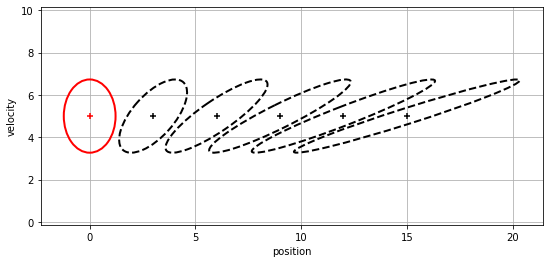

In [64]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

你可以看到速度为5的位置在每6/10的第二步中正确移动3个单位。在每一步中，椭圆的宽度都变大了，这表明由于在每一步中向x添加$\dot x\Delta t$ ，我们丢失了关于位置的信息。高度没有改变-我们的系统模型说速度没有改变，所以我们对速度的信念不会改变。随着时间的推移，你可以看到椭圆变得越来越倾斜。回想一下，倾斜表示*相关性*。$\mathbf F$ 线性关联$x$和$\dot x$与表达式$\bar x = \dot x \Delta t + x$. The $\mathbf{FPF}^\mathsf T$ 计算正确地将这种相关性合并到协方差矩阵中。
 
下面是这个方程的动画，它允许你改变$\mathbf F$的设计，看看它如何影响$\mathbf P$的形状。`F00`滑块影响F[0, 0]的值。`covar`设置位置和速度之间的初始协方差($\sigma_x\sigma_{\dot x}$)。我建议至少回答这些问题
 
* 如果$x$与$\dot x$不相关会怎样?(设置F01为0，其余为默认值)
* 如果$x = 2\dot x\Delta t + x_0$呢?(设置F01为2，其余为默认值)
* 如果$x = \dot x\Delta t + 2x_0$呢?(设置F00为2，其余为默认值)
* 如果$x = \dot x\Delta t$呢?(设置F00为0，其余为默认值)

In [65]:
from ipywidgets import interact
from kf_book.book_plots import IntSlider, FloatSlider

def plot_FPFT(F00, F01, F10, F11, covar):   
    plt.figure()
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, F @ P @ F.T, ec='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    #plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
                 
interact(plot_FPFT, 
         F00=IntSlider(value=1, min=0, max=2), 
         F01=FloatSlider(value=1, min=0, max=2, description='F01(dt)'),
         F10=FloatSlider(value=0, min=0, max=2),
         F11=FloatSlider(value=1, min=0, max=2),
         covar=FloatSlider(value=0, min=0, max=1));

interactive(children=(IntSlider(value=1, continuous_update=False, description='F00', max=2), FloatSlider(value…

(如果你是以静态形式阅读这篇文章:在线运行的说明在这里:https://git.io/vza7b)。或者，使用下面的链接到活页夹，从那里打开这个笔记本。

http://mybinder.org/repo/rlabbe/Kalman-and-Bayesian-Filters-in-Python

### 更新方程
 
更新方程看起来比预测方程更混乱，但这主要是由于卡尔曼滤波在测量空间计算更新。这是因为测量不是*可逆的*。例如，考虑一个给出目标距离的传感器。把距离转换成位置是不可能的——一个圆中无限多个位置将产生相同的距离。另一方面，我们总是可以计算给定位置(状态)的距离(测量值)。
 
在我继续之前，请回忆一下，我们正在尝试做一些非常简单的事情:在测量和预测之间选择一个新的估计，如下图所示:
<img src="./figs/residual_chart.png">

方程会很复杂，因为状态有多个维度，但这就是我们要做的。不要让这些方程式分散你对这个想法的简单性的注意力。

$\underline{\textbf{系统不确定度}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R$
 
为了在测量空间中工作，卡尔曼滤波器必须将协方差矩阵投影到测量空间中。它的数学是$\mathbf{H\bar PH}^\mathsf T$，其中$\mathbf{\bar P}$是*先验*协方差，$\mathbf H$是测量函数。
 
您应该认识到这个$\mathbf{ABA}^\mathsf T$形式-预测步骤使用$\mathbf{FPF}^\mathsf T$用状态转移函数更新$\mathbf P$。在这里，我们使用相同的表单用度量函数来更新它。线性代数改变了我们的坐标系。
 
一旦协方差进入测量空间，我们需要考虑传感器噪声。这很简单，我们只要把矩阵相加。其结果被称为“系统不确定度”或“ 协方差更新”。
 
如果忽略$\mathbf H$项，这个方程等价于卡尔曼增益的单变量方程中的分母:

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

比较系统不确定性方程和协方差方程

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$
 
在每个方程中，$\mathbf P$与函数$\mathbf H$或$\mathbf F$放在不同的空间中。然后我们添加与这个空间相关的噪声矩阵。

$\underline{\textbf{Kalman增益}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$
  
回头看看残差图。一旦我们有了一个预测和测量，我们需要选择一个介于两者之间的估计。如果我们对测量有更多的确定性，估计将更接近它。相反，如果我们对预测有更多的确定性，那么估计就会更接近它。

在单变量那一章中，我们用这个方程缩放了均值

$$
\mu =\frac{\bar\sigma^2 \mu_z + \sigma_\mathtt{z}^2 \bar\mu} {\bar\sigma^2 + \sigma_\mathtt{z}^2}$$

我们将其简化为

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

这给了我们

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$
 
$K$为*卡尔曼增益*，为0到1之间的实数。确保你理解它是如何在预测和测量之间选择一个平均值的。卡尔曼增益是一个*百分比*或*比率* -如果K是.9，它需要90%的测量和10%的预测。

对于多元卡尔曼滤波器，$\mathbf K$是一个向量，而不是一个标量。下面是方程:$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$。这是一个*比率*吗?我们可以把矩阵的逆看作是线性代数中求倒数的方法。没有定义矩阵的除法，但这样想是有用的。因此，我们可以将$\textbf{K}$的方程理解为有意义的


$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{prediction} + \mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$
 
卡尔曼增益方程根据我们对预测和测量的信任程度计算出一个比率。我们在之前的每一章都做了同样的事情。这个方程很复杂，因为我们是在多维矩阵中做的，但概念很简单。 $\mathbf H^\mathsf T$ 项不太清楚，我很快就会解释。如果忽略这一项，卡尔曼增益的方程与单变量情况相同:将先验的不确定性除以先验和测量的不确定性之和。

$\underline{\textbf{残差}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

这是一个简单的方法，因为我们在设计测量函数$\mathbf H$时已经涵盖了这个方程。回想一下，测量函数将状态转换为测量。所以$\mathbf{Hx}$将$\mathbf x$转换为等价的测量值。一旦这样做了，我们可以从测量$\mathbf z$中减去它，得到残差——测量和预测之间的差。

单变量方程是

$$y = z - \bar x$$

显然计算的是同样的东西，但只是一维的。

$\underline{\textbf{State Update}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$
 
我们选择我们的新状态沿着残差，按卡尔曼增益进行缩放。缩放是由$\mathbf{Ky}$执行的，它既缩放残差，又用$\mathbf H^\mathsf T$项将残差转换回状态空间，该项在$\mathbf K$中。这被加到先验中，得到等式:$\mathbf x =\mathbf{\bar x} + \mathbf{Ky}$。我把$\mathbf K$写出来，这样我们就能看到整个计算过程了:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T\mathbf y
\end{aligned}$$

也许更好的方法是重写估计方程:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$

这与单变量形式之间的相似性应该是显而易见的:
$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

$\underline{\textbf{Covariance Update}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$
 
$\mathbf{I}$是单位矩阵，也是我们在多维空间中表示$1$的方式。$\mathbf H$是我们的测量函数，并且是一个常量。我们可以把这个方程看成$\mathbf P = (1-c\mathbf K)\mathbf P$。$\mathbf K$是我们使用多少预测和测量的比率。如果$(1-\mathbf{cK})$大，则$(1-\mathbf{cK})$小，并且$\mathbf P$将变得比原来更小。如果$\mathbf K$较小，则$(1-\mathbf{cK})$较大，而$\mathbf P$相对较大。这意味着我们可以通过卡尔曼增益的某些因素来调整不确定性的大小。
 
这个方程在数值上是不稳定的，我在FilterPy中没有使用它。随着时间的推移，减法会破坏对称性并导致浮点错误。稍后我将分享这个方程更复杂但数值稳定的形式。

### 不使用FilterPy的示例
 
FilterPy对我们隐藏了实现的细节。通常情况下，您会喜欢这个方法，但是让我们实现最后一个不使用FilterPy的过滤器。为此，我们需要将矩阵定义为变量，然后显式地实现卡尔曼滤波方程。
 
这里我们初始化矩阵:

In [1]:
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

NameError: name 'np' is not defined

In [2]:
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)

NameError: name 'compute_dog_data' is not defined

结果与FilterPy版本相同。你喜欢哪一个由你决定。我不喜欢用`x`, `P`等变量污染我的名称空间;`dog_filter.x`。对我来说， 更具可读性。
  
更重要的是，这个例子要求您记住卡尔曼滤波器的方程并编写程序。你迟早会犯错误的。FilterPy的版本确保您的代码是正确的。另一方面，如果您在定义中犯了错误，例如将$\mathbf H$作为列向量而不是行向量，那么FilterPy的错误消息将比此显式代码更难调试。 
 
FilterPy的KalmanFilter类提供了其他功能，如平滑、批处理、褪色记忆滤波、计算最大似然函数等等。您无需显式编程就可以获得所有这些功能。

### 总结
 
我们学过卡尔曼滤波方程。这些都在这里供您审阅。有很多东西要学，但我希望你们在学习每一个的时候能意识到它与单变量过滤器中的方程有亲缘关系。在*卡尔曼数学*一章中，我将向你展示，如果我们将$\mathbf x$的维数设置为1，这些方程就会恢复到单变量滤波器的方程。这不是“类似”单变量过滤器——它是它的多维实现。

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$
 
我想和大家分享一个方程的形式你们会在文献中看到。这里使用了许多不同的符号系统，但这可以让您了解将会发生什么。

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$
 
这个符号使用了贝叶斯$a\mid b$符号，这意味着$a$给出了$b$的证据。帽子的意思是估计。因此，$\hat{\mathbf x}_{k\mid k}$表示根据第k步$k$(第k步)的证据，在第k步$k$(第k步)时状态$\mathbf x$的估计，换句话说，是后验。$\hat{\mathbf x}_{k\mid k-1}$表示给定步长$k -1 $时状态$ mathbf x$的估计。换句话说就是先验。

这个符号，复制自[维基百科](https://en.wikipedia.org/wiki/Kalman_filter#Details) [[1]](#[wiki_article])，允许数学家准确地表达自己。在提出新结果的正式出版物中，这种精度是必要的。作为一个程序员，我发现它相当难读。我习惯于在程序运行时考虑变量状态的变化，并且不会为每次新的计算使用不同的变量名。文学作品没有统一的格式，所以每个作者都有不同的选择。我发现在书和论文之间快速切换很困难，所以我采用了我公认的不那么精确的符号。数学家们可能会给我写尖刻的电子邮件，但我希望程序员和学生们会为我简化的符号感到高兴。

**符号**附录列出了不同作者使用的符号。这又带来了另一个困难。不同的作者使用不同的变量名。$\mathbf x$是相当普遍的，但之后它是任何人的猜测。例如，通常使用$\mathbf{A}$来表示我所说的$\mathbf F$。您必须仔细阅读，并希望作者定义它们的变量(他们通常不会)。
 
如果你是一个程序员，试图理解一篇论文的方程，我建议你先去掉所有的上标、下标和变音符，用一个字母代替它们。如果你每天都和这样的方程打交道，这是多余的建议，但当我阅读时，我通常试图理解计算的流程。对我来说更容易理解记住$ P $在这一步是更新后的值$ P $计算的最后一步,而不是试图记住$P_{k-1}(+)$表示什么,以及它与$P_k(-)$的关系,如果有的话，以及这些与我5分钟前读的论文中使用的完全不同的符号有什么关系。

## 练习:显示隐藏变量的影响

在我们的过滤器中，速度是一个隐藏变量。如果我们不使用状态下的速度，过滤器将如何执行?
 
编写一个使用状态$\mathbf x=\begin{bmatrix}x\end{bmatrix}$的卡尔曼滤波器，并将其与使用 $\mathbf x=\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$的滤波器进行比较。

In [41]:
# your code here

### 解决方案

我们已经实现了一个用于位置和速度的卡尔曼滤波器，所以我将不加太多注释地提供代码，然后绘制结果。

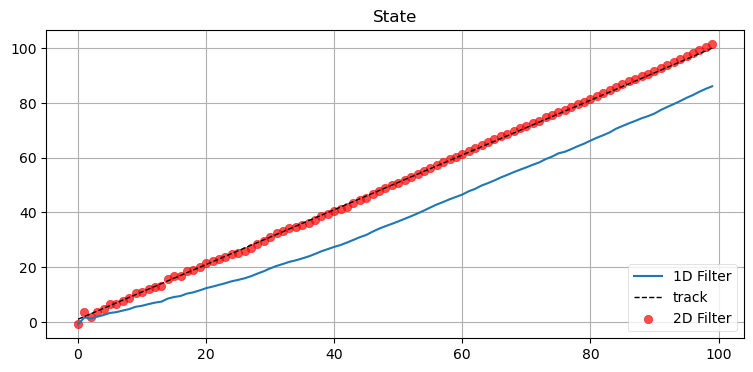

In [42]:
from math import sqrt
from numpy.random import randn

def univariate_filter(x0, P, R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.x = np.array([[x0]])
    f.P *= P
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q *= Q
    f.R *= R
    return f

def plot_1d_2d(xs, xs1d, xs2d):
    plt.plot(xs1d, label='1D Filter')
    plt.scatter(range(len(xs2d)), xs2d, c='r', alpha=0.7, label='2D Filter')
    plt.plot(xs, ls='--', color='k', lw=1, label='track')
    plt.title('State')
    plt.legend(loc=4)
    plt.show()
    
def compare_1D_2D(x0, P, R, Q, vel, u=None):
    # storage for filter output
    xs, xs1, xs2 = [], [], []

    # 1d KalmanFilter
    f1D = univariate_filter(x0, P, R, Q)

    #2D Kalman filter
    f2D = pos_vel_filter(x=(x0, vel), P=P, R=R, Q=0)
    if np.isscalar(u):
        u = [u]
    pos = 0 # true position
    for i in range(100):
        pos += vel
        xs.append(pos)

        # control input u - discussed below
        f1D.predict(u=u)
        f2D.predict()
        
        z = pos + randn()*sqrt(R) # measurement
        f1D.update(z)
        f2D.update(z)
        
        xs1.append(f1D.x[0])
        xs2.append(f2D.x[0])
    plt.figure()
    plot_1d_2d(xs, xs1, xs2)

compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1.) 

### 讨论

与只跟踪位置的滤波器相比，将速度纳入状态的滤波器产生的估计要好得多。单变量滤波器无法估计速度或位置变化，因而滞后于被跟踪对象。 

在单变量卡尔曼滤波一章中，我们对预测方程有一个控制输入`u`:
 
```python
    def predict(self, u=0.0):
        self.x += u
        self.P += self.Q
```

让我们试着指定控制输入:

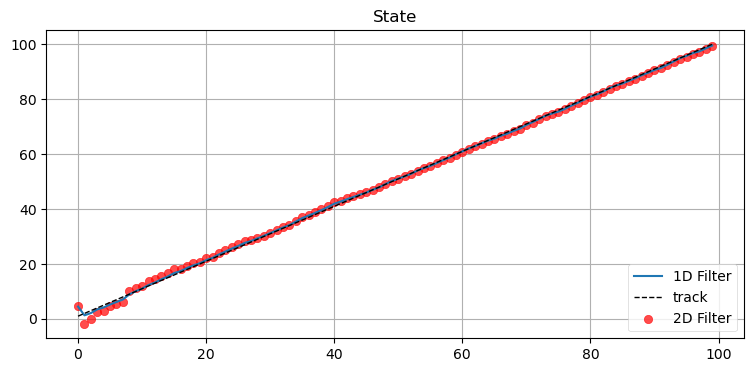

In [43]:
compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1., u=1.) 

在这里，两个滤波器的性能是相似的，也许单变量滤波器跟踪更紧密。但让我们看看当实际速度`vel`与控制输入`u`不同时会发生什么:

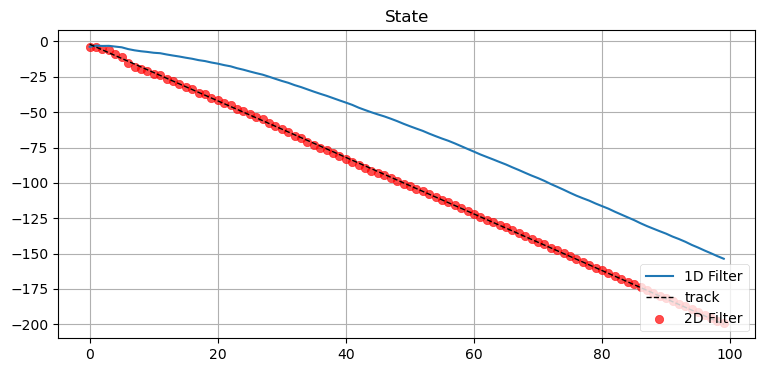

In [44]:
compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=-2., u=1.) 

如果我们跟踪一个机器人我们也控制单变量滤波器可以做得很好，因为控制输入允许滤波器做出准确的预测。但是，如果我们是被动地跟踪控制输入，除非我们能对速度做出准确的“先验的”猜测，否则控制输入没有多大帮助。这几乎是不可能的。

## 如何计算速度

我还没有解释过滤器是如何计算速度或任何隐藏变量的。如果我们代入我们为每个过滤器矩阵计算的值，我们可以看到发生了什么。
 
首先，我们需要计算系统的不确定性。

$$\begin{aligned}
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
&= \begin{bmatrix} 1 & 0\end{bmatrix}
\begin{bmatrix}\sigma^2_x & \sigma_{xv} \\ \sigma_{xv} & \sigma^2_v\end{bmatrix}
\begin{bmatrix} 1 \\ 0\end{bmatrix} + \begin{bmatrix}\sigma_z^2\end{bmatrix}\\
&= \begin{bmatrix}\sigma_x^2 & \sigma_{xv}\end{bmatrix}\begin{bmatrix} 1 \\ 0\end{bmatrix}+ \begin{bmatrix}\sigma_z^2\end{bmatrix} \\
&= \begin{bmatrix}\sigma_x^2 +\sigma_z^2\end{bmatrix}
\end{aligned}$$

现在我们有$\mathbf S$，我们可以找到卡尔曼增益的值:

$$\begin{aligned}
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
&= \begin{bmatrix}\sigma^2_x & \sigma_{xv} \\ \sigma_{xv} & \sigma^2_v\end{bmatrix}
\begin{bmatrix} 1 \\ 0\end{bmatrix}
\begin{bmatrix}\frac{1}{\sigma_x^2 +\sigma_z^2}\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x  \\ \sigma_{xv}\end{bmatrix}
\begin{bmatrix}\frac{1}{\sigma_x^2 +\sigma_z^2}\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x/(\sigma_x^2 +\sigma_z^2)  \\ \sigma_{xv}/(\sigma_x^2 +\sigma_z^2)\end{bmatrix}
\end{aligned}
$$

换句话说，$x$的卡尔曼收益是

$$K_x = \frac{VAR(x)}{VAR(x)+VAR(z)}$$

这在单变量的例子中应该很熟悉。
 
速度$\dot x$的卡尔曼增益是
$$K_{\dot x} = \frac{COV(x, \dot x)}{VAR(x)+VAR(z)}$$

这有什么影响?回想一下，我们计算状态为

$$\begin{aligned}\mathbf x 
&=\mathbf{\bar x}+\mathbf K(z-\mathbf{Hx)} \\
&= \mathbf{\bar x}+\mathbf Ky\end{aligned}$$
 
这里剩余的$y$是一个标量。因此，它被乘到$\mathbf K$的每个元素中。因此我们有

$$\begin{bmatrix}x \\ \dot x\end{bmatrix}=\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} + \begin{bmatrix}K_x \\ K_{\dot x}\end{bmatrix}y$$

它给出了这个方程组:

$$\begin{aligned}x& = \bar x + yK_x\\
\dot x &= \bar{\dot x} + yK_{\dot x}\end{aligned}$$

预测$\bar x$被计算为$x + \bar x \Delta t$。如果预测是完美的，那么残差将是$y=0$(忽略测量中的噪声)，速度估计将保持不变。另一方面，如果速度估计很差，那么预测也会很差，并且残差会很大:$y >> 0$。在这种情况下，我们用$yK_{\dot x}$更新速度估计。$K_{\dot x}$与$COV(x，\dot x)$成正比。因此速度由位置误差乘以与位置和速度之间的协方差成比例的值来更新。相关性越高，修正越大。
 
为了得到这个完整的圆， $COV(x,\dot x)$是$\mathbf P$的非对角线元素。回想一下，这些值是用$\mathbf{FPF}^\mathsf T$计算的。因此，在预测步骤中计算了位置和速度的协方差。速度的卡尔曼增益与这个协方差成正比，我们根据上一个epoch的不准确程度来调整速度估计乘以一个与这个协方差成正比的值。
 
总之，这些线性代数方程你可能不熟悉，但计算实际上是非常简单的。它本质上与我们在g-h滤波器中执行的计算是相同的。在这一章中，我们的常数是不同的，因为我们考虑了过程模型和传感器中的噪声，但数学是相同的。

## 调整滤波器

让我们开始改变参数，看看各种变化的影响。对于卡尔曼滤波器来说这是很正常的事情。要精确地模拟传感器是很困难的，而且往往是不可能的。一个不完美的模型意味着我们的过滤器输出不完美。工程师们花了大量的时间来调整卡尔曼滤波器，使其在现实世界的传感器中表现良好。现在我们将花时间来了解这些变化的影响。当您了解每个变化的影响时，您将对如何设计卡尔曼滤波器有一种直觉。设计卡尔曼滤波器是一门艺术，也是一门科学。我们正在用数学建模一个物理系统，而模型是不完善的。
 
让我们看看测量噪声$\mathbf R$和过程噪声$\mathbf Q$的影响。我们希望看到$\mathbf R$和$\mathbf Q$的不同设置的效果，所以我给了测量的方差为225平方米。这是非常大的，但它放大了图表上各种设计选择的影响，使其更容易识别正在发生的事情。我们的第一个实验保持$\mathbf R$不变，同时改变$\mathbf Q$。

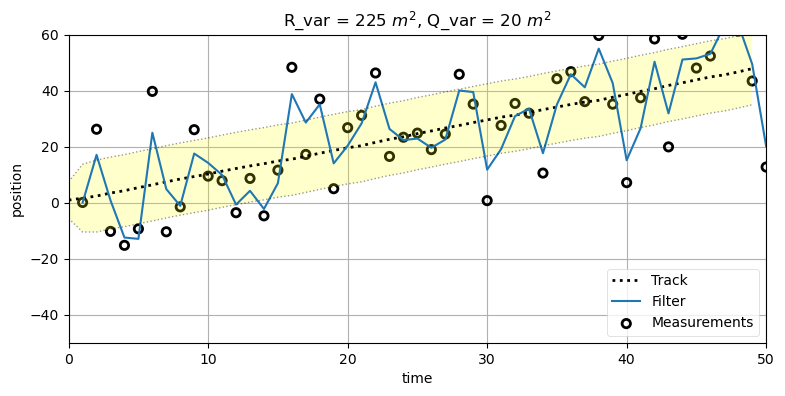

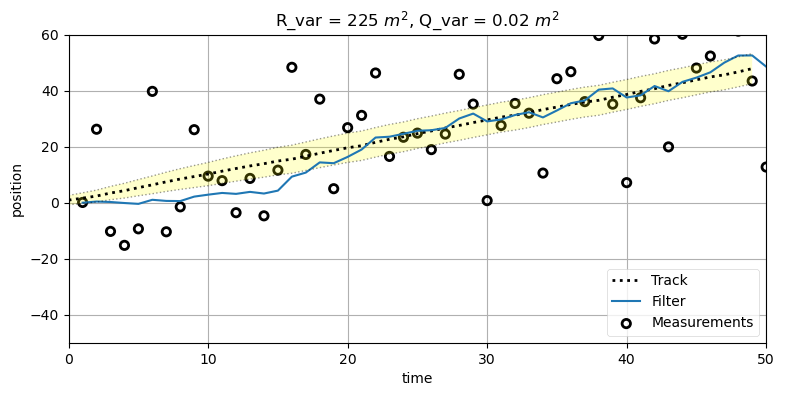

In [45]:
from numpy.random import seed
seed(2)
trk, zs = compute_dog_data(z_var=225, process_var=.02, count=50)

run(track=trk, zs=zs, R=225, Q=200, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 20 $m^2$')
run(track=trk, zs=zs, R=225, Q=.02, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 0.02 $m^2$');

第一个图中的滤波器应密切跟踪噪声测量。在第二个图中，过滤器应该与测量值有很大的不同，并且比第一个图更接近于一条直线。为什么${\mathbf Q}$这样影响绘图?
  
让我们回顾一下*过程不确定性*这个术语的含义。考虑跟踪一个球的问题。我们可以用数学精确地模拟它在真空中的行为，但如果有风、变化的空气密度、温度和一个表面不完美的旋转球，我们的模型就会偏离现实。
 
在第一个例子中，我们设置了`Q_var=20 m^2`，这个值相当大。在物理术语中，这是告诉过滤器"我不相信我的运动预测步骤"因为我们说，速度的方差是20。严格地说，我们告诉滤波器有很多外部噪声，我们不是用$\small{\mathbf F}$建模的，但这样做的结果是不相信运动预测步骤。过滤器将计算速度($\dot x$)，但大多数情况下会忽略它，因为我们告诉过滤器，计算是非常可疑的。因此，除了测量值之外，过滤器没有任何可信任的东西，因此它与测量值密切相关。
 
在第二个例子中，我们设置了`Q_var=0.02 m^2`'，这个值非常小。用物理术语来说，我们是在告诉过滤器“相信预测，它真的很棒!”更严格地说，这实际上是说有非常少量的过程噪声(方差0.02 $m^2$)，所以过程模型是非常准确的。所以当它上下跳动时，滤波器最终会忽略一些测量值，因为测量值的变化与我们可靠的速度预测不匹配。
 
现在让我们将`Q_var`设置为$0.2\，m^2$，并将`R_var`设置为$10,000\，m^2$。这告诉滤波器测量噪声非常大。

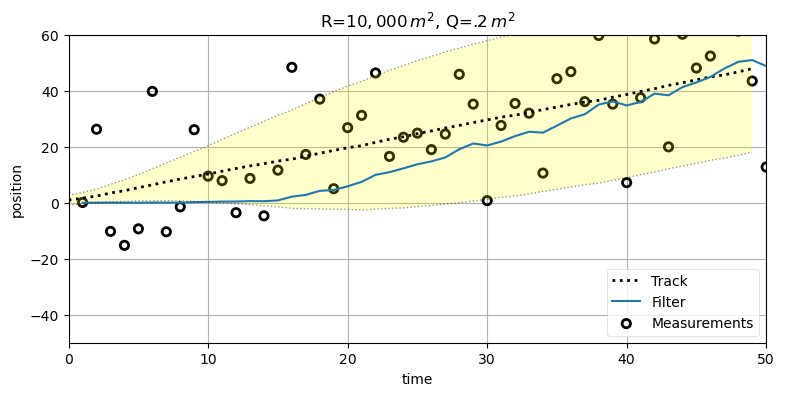

In [46]:
run(track=trk, zs=zs, R=10000, Q=.2, P=P, plot_P=False, 
    title='R=$10,000\, m^2$, Q=$.2\, m^2$');

这种影响可能是不易察觉的。我们创建了一个次优滤波器，因为实际测量噪声方差是225 $m^2$，而不是10,000 $m^2$。通过设置滤波器的噪声方差如此之高，我们迫使滤波器更倾向于预测而不是测量。这可以导致非常平滑和好看的结果。在上面的图表中，这条轨迹可能对你来说非常好，因为它非常接近理想的路径。但是，“伟大”的行为在开始时应该给你暂停-过滤器还没有收敛($\mathbf P$仍然很大)，所以它不应该能够如此接近实际位置。我们可以看到$\mathbf P$没有收敛，因为整个图表用黄色背景表示$\mathbf P$的大小。让我们看看一个错误的初始位置猜测的结果通过猜测初始位置是50米初始速度是1m /s。

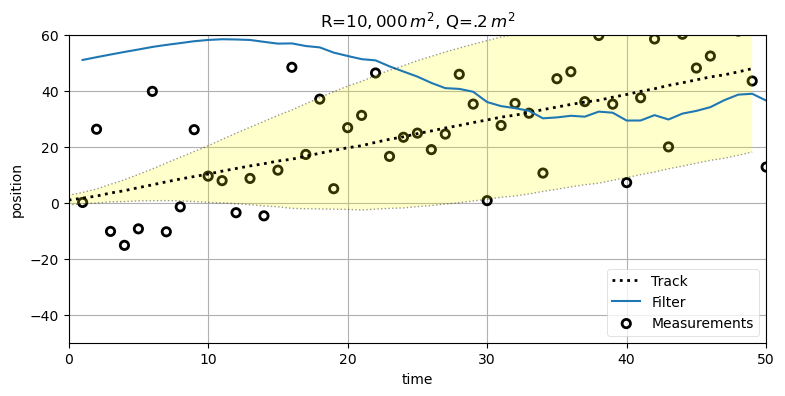

In [47]:
run(track=trk, zs=zs, R=10000, Q=.2, P=P, plot_P=False,
    x0=np.array([50., 1.]), 
    title='R=$10,000\, m^2$, Q=$.2\, m^2$');

这里我们可以看到，滤波器无法获取轨迹。发生这种情况的原因是，尽管过滤器得到了相当好的测量值，但它假设测量值是坏的，并最终在每一步从一个坏位置预测前进。如果你认为在较小的测量噪声下，糟糕的初始位置可能会给出类似的结果，让我们把它设回正确的值225 $m^2$。

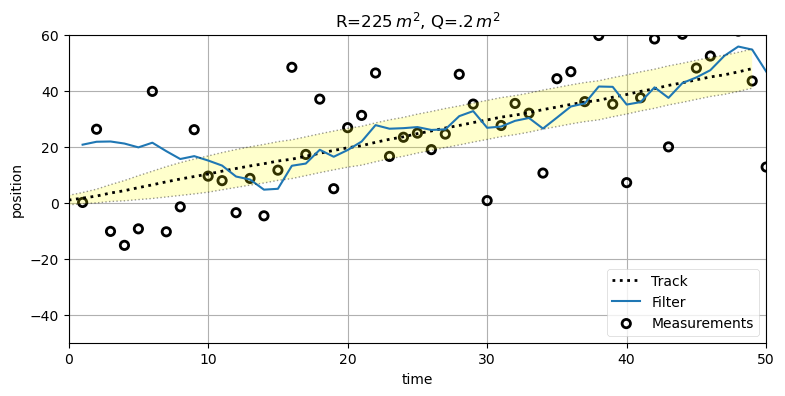

In [48]:
run(track=trk, zs=zs, R=225, Q=.2, P=P, plot_P=False, 
    x0=np.array([20., 1.]),
    title='R=$225\, m^2$, Q=$.2\, m^2$');

在这里，我们看到过滤器最初为获得轨迹而挣扎了几次迭代，但随后它准确地跟踪了我们的狗。事实上，这几乎是最优的-我们没有设计$\mathbf Q$，但$\mathbf R$是最优的。对于$\mathbf Q$，经验法则是将它设置在$\frac{1}{2}\Delta a$和$\Delta a$之间，其中$\Delta a$是在样本周期之间加速度变化的最大值。这只适用于我们在本章中所做的假设——加速度是恒定的，并且在每个时间段之间不相关。在卡尔曼数学一章中，我们将讨论几种不同的设计$\mathbf Q$的方法。

在某种程度上，您可以通过改变${\mathbf R}$或${\mathbf Q}$来获得类似的输出，但我建议您不要“神奇地”更改这些输出，直到得到您喜欢的输出。总是考虑这些赋值的物理含义，并根据你对所过滤系统的了解来改变${\mathbf R}$和/或${\mathbf Q}$。用大量的模拟和/或真实数据的试验运行来支持这一点。

##  协方差矩阵的详细检验
 
让我们从重新绘制轨道开始。我在`zs_var_275` 中硬编码了数据和噪声，以避免受随机数生成器的支配，因为它可能生成的数据不能说明我想要讨论的内容。我将从`P=500`开始。

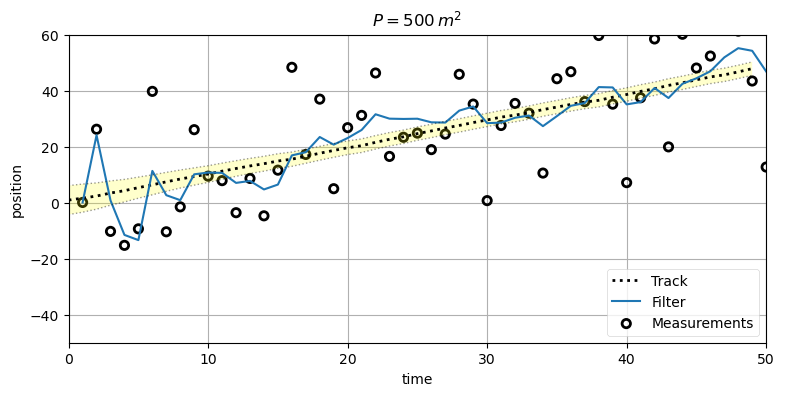

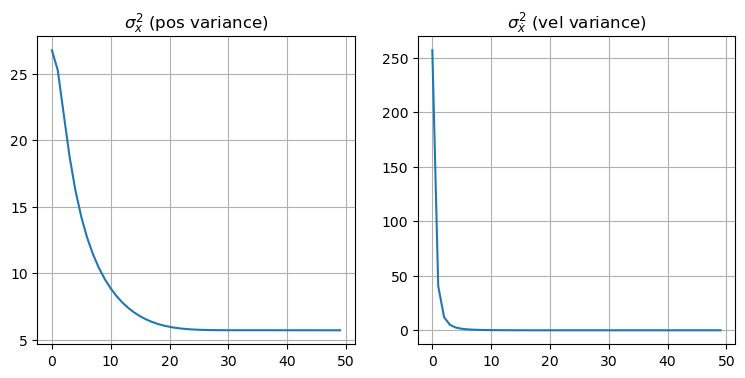

In [49]:
import kf_book.mkf_internal as mkf_internal

var = 27.5
data = mkf_internal.zs_var_275()
run(track=trk, zs=zs, R=var, Q=.02, P=500., plot_P=True, 
    title='$P=500\, m^2$');

看看输出，我们看到一个非常大的尖峰在滤波器输出在开始。我们设置$\text{P}=500\， \mathbf{I}_2$(这是对角线上有500的2x2对角矩阵的简写)。我们现在有足够的信息来理解这意味着什么，以及卡尔曼滤波器是如何处理它的。左上角的500对应于$\sigma^2_x$;因此，我们说x的标准差是$\sqrt{500}$，或大约22.36 m。大约99%的样本发生在$3\sigma$内，因此$\sigma^2_x=500$告诉卡尔曼滤波器预测(先验预测)最远可达67米。这是一个很大的误差，所以当测量峰值时，卡尔曼滤波器不相信它自己的估计，并疯狂地跳跃试图纳入测量。然后，随着过滤器的发展，$\mathbf P$迅速收敛到一个更现实的值。

让我们看看这背后的数学。卡尔曼增益的方程是

$$\mathbf K = \mathbf{\bar P} \mathbf H^\mathsf T\mathbf{S}^{-1} \approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} 
\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
$$
 
它是预测与测量的不确定度之比。这里预测的不确定性很大，所以$\mathbf K$很大(如果这是一个标量，接近1)。$\mathbf K$乘以剩余的$\textbf{y} = \mathbf z - \mathbf{H \bar x}$，即测量减去预测，所以较大的$\mathbf K$有利于测量。因此，如果$\mathbf P$相对于传感器不确定性$\mathbf R$较大，则滤波器将形成来自测量的大部分估计。
 
现在让我们看看较小的初始值$\mathbf P = 1.0\， \mathbf{I}_2$的效果。

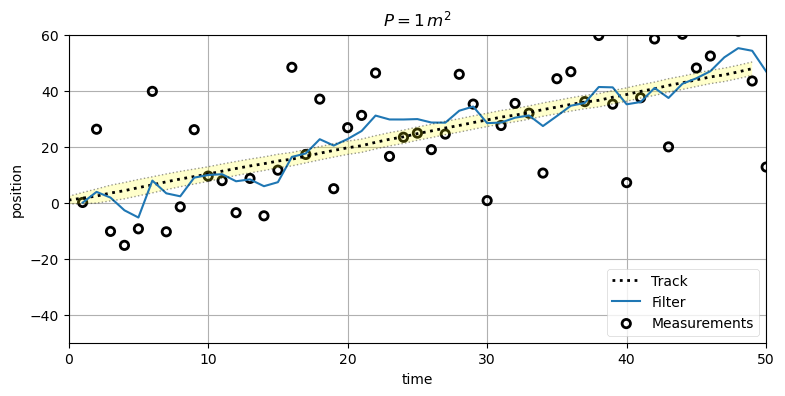

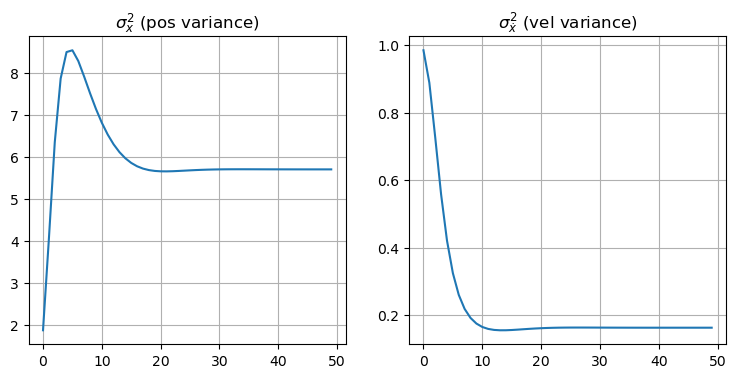

In [50]:
run(track=trk, zs=zs, R=var, Q=.02, P=1., plot_P=True, 
    title='$P=1\, m^2$');

乍一看，这个看起来不错。这个情节没有前一个情节的峰值;滤波器开始跟踪测量值，不需要任何时间来适应信号。但是，如果我们看P的图，你可以看到在位置上有一个初始的方差尖峰，它从来没有真正收敛。糟糕的设计会导致较长的收敛时间，并导致次优结果。
 
因此，尽管滤波器跟踪非常接近实际的信号，我们不能得出“魔法”是使用一个小的$\mathbf P$。是的，这将避免卡尔曼滤波器花费时间来精确跟踪信号，但如果我们真的不确定初始测量值，这将导致滤波器产生非常糟糕的结果。如果我们在追踪一个活体，在我们开始追踪它之前，我们可能对它的位置非常不确定。另一方面，如果我们过滤温度计的输出，我们对第一次测量和第1000次测量一样确定。为了使卡尔曼滤波性能良好，您必须将$\mathbf P$设置为一个真正反映您对数据的了解的值。
 
让我们看看一个糟糕的初始估计加上一个非常小的$\mathbf P$的结果。我们将初始估计设为x = 100 m(而狗实际上从0m开始)，但设' P=1 ' m$^2$。对于$\mathbf P$，这显然是一个不正确的值，因为估计误差为100 m，但我们告诉过滤器，$3\sigma$误差为3 m。

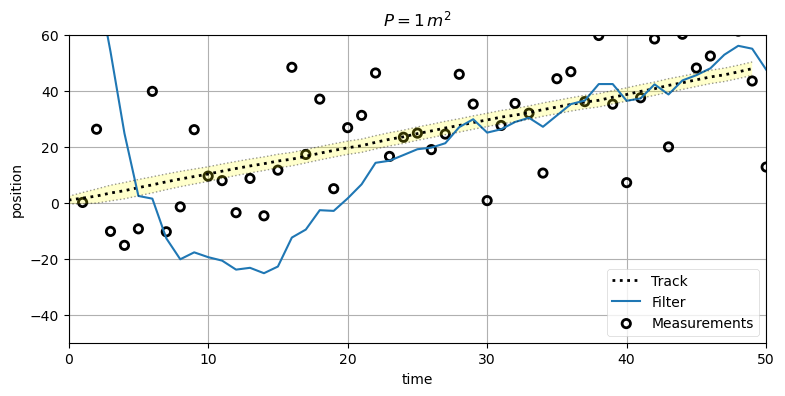

In [51]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=1., x0=x,
    plot_P=False, title='$P=1\, m^2$');

我们可以看到，初始估计很糟糕，滤波器需要很长时间才能开始收敛到信号上。这是因为我们告诉卡尔曼滤波器，我们强烈相信我们对100米的初始估计，但这个估计是错误的。
 
现在，让我们为' P '提供一个更合理的值，看看有什么不同。

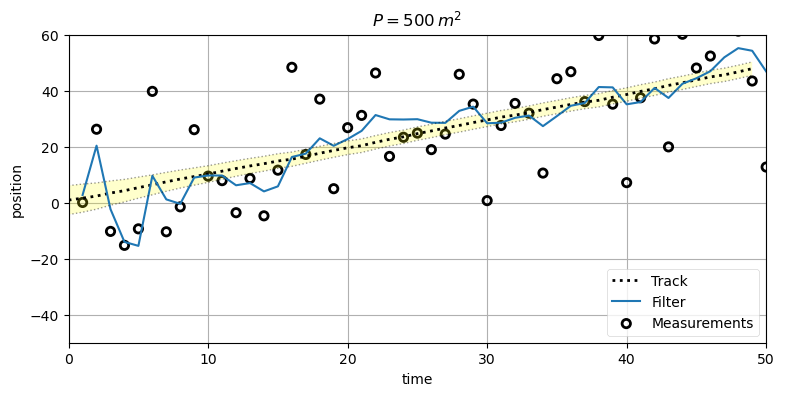

In [52]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=500., x0=x,
   plot_P=False, title='$P=500\, m^2$');

在这种情况下，卡尔曼滤波器对初始状态非常不确定，所以它对信号收敛得更快。仅经过5到6个时代，它就产生了良好的产量。根据我们目前所开发的理论，这已经是我们能做的最好的了。然而，这个场景有点人为;如果我们不知道对象在哪里，当我们开始跟踪时，我们不初始化滤波器的一些任意值，如0米或100米。我在下面的**过滤器初始化部分解决了这个问题**。
 
我们再对狗做一个卡尔曼滤波，这次把协方差椭圆画在和位置相同的图上。

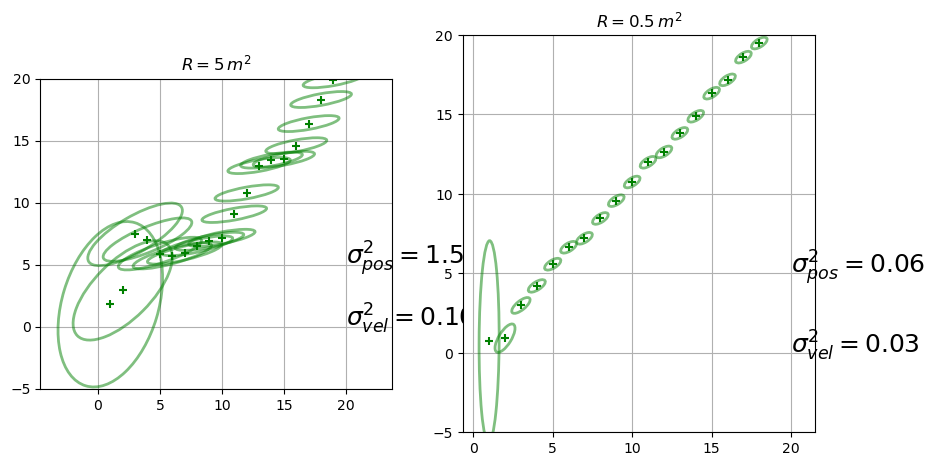

In [53]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=0, P=20., title=''):    
    track, zs = compute_dog_data(R, Q, count)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize=(10,6))
plt.subplot(121)
plot_covariances(R=5, Q=.02, count=20, title='$R = 5\, m^2$')
plt.subplot(122)
plot_covariances(R=.1, Q=.02, count=20, title='$R = 0.5\, m^2$')

如果你是在木星笔记本或在网上看这个，这是一个过滤器过滤数据的动画。我已经调优了过滤器参数，以便在过滤器进行过程中很容易看到$\mathbf P$中的变化。
<img src='animations/multivariate_track1.gif'>

这些输出有点混乱，但你应该能看到发生了什么。在这两幅图中，我们都画出了每个点的协方差矩阵。我们从协方差$\mathbf P=(\begin{smallmatrix}20&0\\0&20\end{smallmatrix})$开始，这表示我们的初始信念有很多不确定性。在我们收到第一个测量值后，卡尔曼滤波器更新了这个信念，因此方差不再那么大。在上图中，第一个椭圆(最左边的那个)应该是一个稍微压扁的椭圆。当滤波器继续处理测量值时，协方差椭圆会迅速改变形状，直到它稳定下来成为一个长而窄的、向运动方向倾斜的椭圆。

想想这在物理上意味着什么。椭圆的x轴表示位置的不确定性，y轴表示速度的不确定性。所以，一个高过宽的椭圆表示我们对速度的不确定性大于对位置的不确定性。相反，宽而窄的椭圆表示位置的高不确定性和速度的低不确定性。最后，倾斜的大小显示了这两个变量之间的相关性。
 
第一个图形，$R=5 m^2$，以宽大于高的椭圆结束。如果不清楚，我已经在右下角打印出了最后一个椭圆的方差。
 
相比之下，第二个带有`R=0.5` $m^2$的plot，其最终椭圆的高度大于宽度。第二个图中的省略号都比第一个图中的省略号小得多。这是有道理的，因为一个很小的$\small\mathbf R$意味着在我们的测量中有少量的噪声。小的噪声意味着准确的预测，因此对我们的位置有很强的信念。

## 问题:解释椭圆的差异
 
为什么$\mathbf R=5 m^2$的椭圆比$\mathbf R=0.5 m^2$的椭圆更倾向于水平方向?提示:考虑这些椭圆的物理意义，而不是数学意义。如果你不确定答案，将$\mathbf R$改为真正的大或小的数字，如100 $m^2$和0.1 $m^2$，观察这些变化，并思考这意味着什么。

### 解答

x轴表示位置，y轴表示速度。垂直或接近垂直的椭圆表示位置和速度之间没有相关性，而对角线的椭圆表示有很多相关性。这样的话，结果听起来不太可能。椭圆的倾斜度会改变，但相关性不应随时间而改变。但这是对“过滤器输出”的衡量，而不是对实际物理世界的描述。当$\mathbf R$非常大时，我们告诉滤波器在测量中有很多噪声。在这种情况下，卡尔曼增益$\mathbf K$被设置为有利于预测而不是测量，而预测来自速度状态变量。因此，在$x$和$\dot x$之间有很大的相关性。相反，如果$\mathbf R$很小，我们就告诉过滤器测量是非常可靠的，并且$\mathbf K$被设置为更有利于测量而不是预测。如果测量几乎是完美的，为什么过滤器要使用预测?如果过滤器不从预测中使用太多，那么报告的相关性将非常少。
   
这是一个需要理解的关键点!卡尔曼滤波器是一个真实世界系统的数学模型。相关性小的报告并不意味着物理系统中没有相关性，只是数学模型中没有线性相关性。这是一个关于模型中包含了多少测量和预测的报告。
 
让我们用一个非常大的测量误差来说明这一点。我们设$\mathbf R=200\, m^2$。在看它之前，想想它会是什么样子。

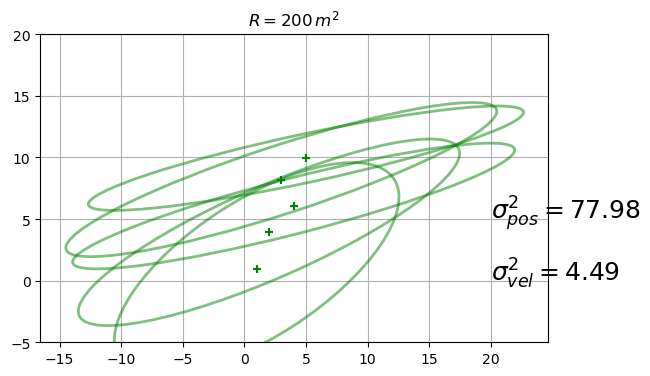

In [54]:
plot_covariances(R=200., Q=.2, count=5, title='$R = 200\, m^2$')

要使用预测而不是测量来产生滤波结果。我们还可以看到滤波器的输出是如何缓慢地获取跟踪的。卡尔曼滤波器假设测量值非常嘈杂，因此更新$\dot x$的估计非常缓慢。
  
继续看这些图，直到你掌握了如何解释协方差矩阵$\mathbf P$。当你处理$9{\times}9$矩阵的时候，它可能看起来让人不知所措——有81个数字需要解释。对角线上包含了每个状态变量的方差，所有非对角线上的元素都是两个方差和一个比例因子$p$的乘积。你不能在屏幕上绘制$9{\times}9$矩阵，所以你必须在这个简单的二维情况下培养你的直觉和理解。
 
>当绘制协方差椭圆时，确保在代码中始终使用ax.set_aspect('equal')或plt.axis('equal')(前者允许设置xlim和ylim值)。如果轴使用不同的比例，椭圆将被绘制扭曲。例如，椭圆可能被画成高大于宽，但实际上它可能是宽大于高。

## 滤波器初始化
 
有许多初始化过滤器的方案。下面的方法在大多数情况下运行良好。在这个方案中，在得到第一个度量值$\mathbf z_0$之前，您不会初始化过滤器。由此，你可以用$\mathbf x_0 = \mathbf z_0$来计算$\mathbf x$的初始值。如果$\mathbf z$的大小、类型和单位与$\mathbf x$不同，这是通常的情况，我们可以使用下面的测量函数。

我们知道

$$\mathbf z = \mathbf{Hx}$$

因此,

$$\begin{aligned}
\mathbf H^{-1}\mathbf{Hx} &= \mathbf H^{-1}\mathbf z \\
\mathbf x &= \mathbf H^{-1}\mathbf z\end{aligned}$$
 
矩阵逆需要一个方阵，但是$\mathbf H$很少是方阵。SciPy将用SciPy .linalg计算矩阵的摩尔-彭罗斯伪逆。`scipy.linalg.pinv`，所以你的代码看起来像

In [55]:
from scipy.linalg import pinv

H = np.array([[1, 0.]]) 
z0 = 3.2
x = np.dot(pinv(H), z0)
print(x)

[[3.2]
 [0. ]]


对问题领域的专业知识可能会引导您进行不同的计算，但这是一种方法。例如，如果状态包含速度，你可以用前两次位置测量，计算差值，并将其作为初始速度。
 
现在我们需要计算$\mathbf P$的值。这将因问题而异，但通常您将使用测量误差$\mathbf R$用于相同的项，并对其余项使用最大值。也许这还不清楚。在这一章中，我们一直使用位置和速度作为状态来跟踪和物体，测量的是位置。在这种情况下，我们将初始化$\mathbf P$

$$\mathbf P = \begin{bmatrix}\mathbf R_0 & 0 \\0 & vel_{max}^2\end{bmatrix}$$
 
$\mathbf P$的对角线包含每个状态变量的方差，因此我们用合理的值填充它。$\mathbf R$是位置的合理方差，最大速度平方是速度的合理方差。它是平方，因为方差是平方，$\sigma^2$。
 
您确实需要了解正在工作的领域，并根据最佳可用信息初始化筛选器。例如，假设我们要在赛马比赛中追踪马匹。最初的测量可能非常糟糕，并提供给你一个远离起点的位置。我们知道，马必须从起跑门出发;将过滤器初始化到初始测量将导致次优结果。在这个场景中，我们希望始终用马的出发门位置初始化卡尔曼滤波器。

## 批量处理
 
卡尔曼滤波器被设计成一种递归算法——当新的测量值进来时，我们立即创建一个新的估计。但是，我们通常会有一组已经收集到的需要过滤的数据。卡尔曼滤波器可以在批处理模式下运行，其中所有的测量都是一次性过滤的。我们已经在' `KalmanFilter.batch_filter()`中实现了这个 。在内部，该函数所做的就是循环测量，并在数组中收集结果状态和协方差估计。它简化了逻辑并方便地将所有输出收集到数组中。我经常使用这个函数，但要等到本章结束时，这样您就会非常熟悉必须运行的预测/更新周期。

首先将度量值收集到一个数组或列表中。可能是在CSV文件中:

```python
zs = read_altitude_from_csv('altitude_data.csv')
```
或者你可以使用生成器来生成它:

```python
zs = [some_func(i) for i in range(1000)]
```
然后调用`batch_filter()`方法。
 
```python
Xs, Ps, Xs_prior, Ps_prior = kfilter.batch_filter(zs)
```
 
该函数获取测量值列表，对其进行过滤，并返回状态估计(Xs)、协方差矩阵(Ps)和相同的先验值(Xs_prior, Ps_prior)的NumPy数组。

下面是一个完整的例子。

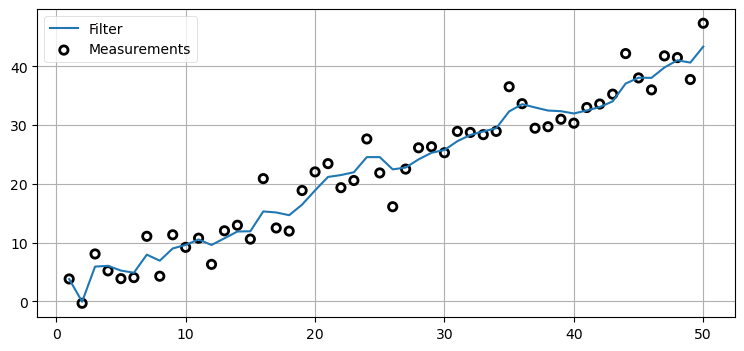

In [56]:
count = 50
track, zs = compute_dog_data(10, .2, count)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc='best');

批处理过滤器接受一个可选的 `filterpy.common.Saver` 对象。如果提供，也将保存过滤器的所有属性。如果您想要检查状态和协方差以外的值，这是非常有用的。我在这里画出残差，看看它是否像以0为中心的噪声。这是一个快速的视觉检查，看看过滤器是否设计良好。如果从零漂移，或看起来不像噪声，滤波器设计很差，或过程不是高斯。我们将在后面的章节中详细讨论这一点。现在，把这看作是对`Saver`类的演示。

In [1]:
track, zs = compute_dog_data(10, .2, 200)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
s = Saver(f)
xs, _, _, _ = f.batch_filter(zs, saver=s)
s.to_array()
plt.plot(s.y);

NameError: name 'compute_dog_data' is not defined

## 平滑的结果
 
这本书包括一个关于平滑结果的章节;我不会在这里重复这些信息。但是，它非常容易使用，并且提供了非常好的输出，因此我将用一些示例来挑逗您。平滑的那一章并不特别困难;你现在已经准备好阅读它了。
 
假设我们在追踪一辆沿直线行驶的汽车。我们得到的测量数据表明汽车开始向左转。卡尔曼滤波器将状态估计稍微移向测量值，但它不能判断这是一个特别嘈杂的测量值还是一个真正的转弯开始。

然而，如果我们有未来的测量，我们可以决定是否转弯。假设随后的测量都继续左转。这样我们就可以确定一个转折开始了。另一方面，如果随后的测量继续在一条直线上，我们就会知道测量是有噪声的，应该被忽略。而不是在测量和预测之间进行部分估计，这个估计要么完全包含测量，要么忽略它，这取决于未来的测量对物体运动的暗示。
 
`KalmanFilter`实现了这种算法的一种形式，称为*RTS平滑器*，以算法的发明者Rauch、Tung和Striebel的名字命名。方法是 `rts_smoother()`。要使用它，需要通过`batch_filter` 步骤计算的平均值和协方差，并接收到平滑的平均值、协方差和卡尔曼增益。

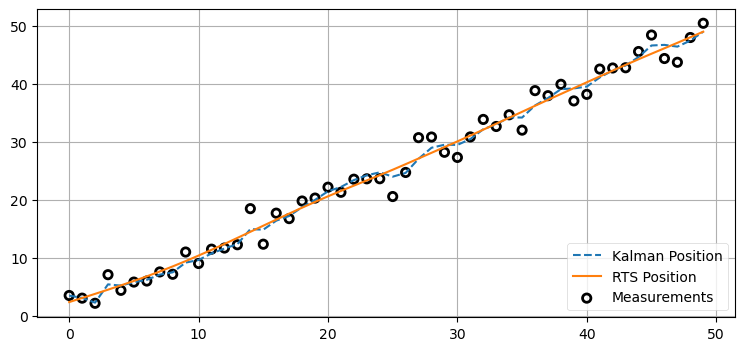

In [58]:
from numpy.random import seed
count = 50
seed(8923)

P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
track, zs = compute_dog_data(3., .02, count)
Xs, Covs, _, _ = f.batch_filter(zs)
Ms, Ps, _, _ = f.rts_smoother(Xs, Covs)

book_plots.plot_measurements(zs)
plt.plot(Xs[:, 0], ls='--', label='Kalman Position')
plt.plot(Ms[:, 0], label='RTS Position')
plt.legend(loc=4);

这个输出棒极了!在这张图表中，我很清楚地看到两件事。首先，RTS平滑器的输出比KF输出更平滑。其次，它几乎总是比KF输出更准确(我们将在**平滑**章节详细检查这一声明)。速度的改善(这是一个隐藏变量)甚至更加显著:

In [2]:
plt.plot(Xs[:, 1], ls='--', label='Kalman Velocity')
plt.plot(Ms[:, 1], label='RTS Velocity')
plt.legend(loc=4)
plt.gca().axhline(1, lw=1, c='k');

NameError: name 'plt' is not defined

我们将在下一个练习中探索为什么会这样。

## 练习:比较速度
 
由于我们正在绘制速度，让我们看看“原始”速度是什么，我们可以通过减去后续测量值来计算。即时间1时的速度可以近似为`xs[1] - xs[0]`。将原始值与卡尔曼滤波器和RTS滤波器估计的值进行对比。讨论你所看到的。

In [60]:
# your code here

### 答案

In [3]:
dx = np.diff(Xs[:, 0], axis=0)
plt.scatter(range(1, len(dx) + 1), dx, facecolor='none', 
            edgecolor='k', lw=2, label='Raw velocity')
plt.plot(Xs[:, 1], ls='--', label='Filter')
plt.plot(Ms[:, 1], label='RTS')
plt.legend(loc=4);

NameError: name 'np' is not defined

我们看到，噪声淹没了信号，导致原始值基本上毫无价值。过滤器对速度保持一个单独的估计。卡尔曼增益$\mathbf K$是多维的。例如，它的值可能是$\mathbf K = [0.1274, 0.843]^\mathsf T$。第一个值用于缩放位置的残差，第二个值用于缩放速度的残差。协方差矩阵告诉滤波器位置和速度是如何相关的，每个都将被最佳地过滤。
 
我展示这一点是为了重申使用卡尔曼滤波器计算速度、加速度甚至更高阶值的重要性。我使用卡尔曼滤波，即使我的测量是如此准确，我愿意使用它们不过滤，因为它允许我准确估计速度和加速度。

## 讨论和总结

多元高斯允许我们同时处理多个维度，包括空间维度和其他维度(速度等)。我们得出了一个关键的见解:隐藏变量有能力显著提高过滤器的准确性。这是可能的，因为隐藏变量与观察变量相关。
 
我给出了“可观察性”的直观定义。可观察性是卡尔曼博士为线性系统发明的，这背后有大量的理论支持。它回答了一个问题:系统状态是否可以通过观察系统的输出来确定。对于我们的问题，这很容易确定，但更复杂的系统可能需要严格的分析。对于我们的问题，这很容易确定，但更复杂的系统可能需要严格的分析。维基百科的[Observability](https://en.wikipedia.org/wiki/Observability)文章有一个概述;如果你需要学习这个话题[[Grewal2008]](#References)是一个很好的来源。

关于隐藏变量有一个重要的警告。构造一个对隐藏变量进行估计的过滤器是很容易的。我可以写一个过滤器来估计跟踪车的颜色。但是没有办法从位置来计算汽车颜色，所以对颜色的估计将是无意义的。设计者必须验证这些变量的估计是正确的。如果您没有速度传感器，但仍在估计速度，您将需要测试速度估计是否正确。不要相信他们。例如，假设速度有一个周期分量它看起来像一个正弦波。如果你的采样时间小于频率的2倍，你将无法准确估计速度(由于奈奎斯特定理)。假设采样周期等于速度的频率。滤波器将报告速度是恒定的，因为它在正弦波上的同一点采样系统。
 
初始化给隐藏变量带来了一个特别困难的问题。如果初始化错误，过滤器通常可以恢复观察到的变量，但隐藏的变量可能难以恢复并失败。估计隐藏变量是一个强大的工具，但也是一个危险的工具。
 
我建立了一系列设计卡尔曼滤波器的步骤。这些并不是卡尔曼滤波文献中常见的部分，只是作为一种指导，而不是处方。针对困难问题的设计是一个迭代过程。您可以猜测状态向量，计算出度量和状态模型，运行一些测试，然后根据需要更改设计。
 
$\mathbf R$和$\mathbf Q$的设计通常是相当具有挑战性的。我让它看起来很科学。您的传感器有高斯噪声$\mathcal{N}(0， \sigma^2)$，所以设置$\mathbf R= sigma^2$。简单!这是一个肮脏的谎言。传感器不是高斯分布的。我们从浴室磅秤开始读这本书。假设$\sigma=1$ kg，你试着给一个重0.5 kg的东西称重。理论告诉我们，我们会得到负的测量值，但当然，体重秤永远不会报告小于零的重量。真实世界的传感器通常有“胖尾”(称为“峰度”)和“偏度”。在某些情况下，例如在天平上，一个或两个尾巴被截断。
 
$\mathbf Q$的情况更可怕。我希望当我愉快地将噪声矩阵分配给我对狗的动作的预测时，你会有所怀疑。谁知道狗接下来会做什么?我GPS里的卡尔曼滤波器不知道山坡，外面的风，或者我糟糕的驾驶技术。然而，这个过滤器需要一个精确的数字来概括所有的信息，它需要在我在沙漠中越野车时工作，也需要在一级方程式冠军在赛道上行驶时工作。
  
这些问题导致一些研究人员和工程师蔑称卡尔曼滤波器为“泥球”。换句话说，它并不总是很好地结合在一起。另一个需要知道的术语-卡尔曼滤波器可以变得“自鸣得意”。他们的估计仅仅是基于你告诉它的噪音是什么。这些值可能导致过度自信的估计。$\mathbf P$变得越来越小，而过滤器实际上变得越来越不准确!在最坏的情况下，滤波器发散。当我们开始学习非线性滤波器时我们会看到很多。
 
卡尔曼滤波器是世界上的一个数学模型。输出只和模型一样准确。为了让数学更容易理解，我们必须做一些假设。我们假设传感器和运动模型具有高斯噪声。我们假设一切都是线性的。如果这是真的，卡尔曼滤波器在最小二乘意义上是*最优的*。这意味着没有比过滤器给我们的更好的估计方法了。然而，这些假设几乎都不成立，因此模型必然是有限的，一个有效的过滤器很少是最优的。
 
在以后的几章中，我们将讨论非线性问题。现在我想让你们明白设计线性滤波器的矩阵是一个实验过程而不是一个数学过程。用数学来建立初始值，然后需要进行实验。如果世界上有很多无法计算的噪音(风，等等)，你可能需要使$\mathbf Q$更大。如果您把它设置得太大，筛选器就不能快速响应更改。在“自适应滤波器”一章中，您将学习一些替代技术，这些技术允许您根据输入和性能实时更改滤波器设计，但目前您需要找到一组适用于滤波器将遇到的条件的值。如果飞行员是学生，那么杂耍飞机的噪声矩阵可能与飞行员是专家的飞机的噪声矩阵是不同的，因为动力学是完全不同的。

## 参考文献

- <A name="[wiki_article]">[1]</A> 'Kalman Filters'. Wikipedia
https://en.wikipedia.org/wiki/Kalman_filter#Details

* **[Grewal2008]** Grewal, Mohinder S., Andrews, Angus P. *Kalman Filtering: Theory and Practice Using MATLAB*. Third Edition. John Wiley & Sons. 2008.